In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import keras
import tensorflow as tf
from keras.applications import ResNet152V2, ResNet50V2
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Input
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle

Generate Data From chest_xray Folder:
* Here we split the data in a way that we have bacteria, virus and normal images. in the proper way- some of each and not in a total randomize way
* TODO: Need to chek why the depth of the image is 3 and not 1 as in regular cnn network

In [5]:
# IMG_SIZE = 150
IMG_DEPTH = 3
IMG_SIZE = 224
BATCH = 16
SEED = 42

normal_dataset = glob.glob('/content/drive/MyDrive/Deep Learning Project/chest_xray/NORMAL/*.jpeg')
pneumonia_dataset = glob.glob('/content/drive/MyDrive/Deep Learning Project/chest_xray/PNEUMONIA/*.jpeg')
virus_dataset = list(filter(lambda x: 'virus' in x, pneumonia_dataset))
bacterial_dataset = list(filter(lambda x: 'bacteria' in x, pneumonia_dataset))


Generate Train, Validation and Test Sets:

In [6]:
def split_data(dataSet, testSize, valSize):
    train, test= train_test_split(dataSet, test_size=testSize, random_state=SEED, shuffle=True)
    train, val= train_test_split(train, test_size=valSize, random_state=SEED, shuffle=True)
    return train, test, val


train_normal, test_normal, val_normal = split_data(normal_dataset, 0.15, 0.038)
train_bacterial, test_bacterial, val_bacterial = split_data(bacterial_dataset, 0.05, 0.0095)
train_virus, test_virus, val_virus = split_data(virus_dataset, 0.075, 0.019)



train = [x for x in train_normal]
train.extend([x for x in train_bacterial])
train.extend([x for x in train_virus])

test = [x for x in test_normal]
test.extend([x for x in test_bacterial])
test.extend([x for x in test_virus])

val = [x for x in val_normal]
val.extend([x for x in val_bacterial])
val.extend([x for x in val_virus])

df_train = pd.DataFrame(np.concatenate([['Normal']*(len(train_normal)) , ['Pneumonia']*(len(train_bacterial) + len(train_virus))]), columns = ['class'])
df_train['image'] = [x for x in train]

df_val = pd.DataFrame(np.concatenate([['Normal']*(len(val_normal)) , ['Pneumonia']*(len(val_bacterial) + len(val_virus))]), columns = ['class'])
df_val['image'] = [x for x in val]

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*(len(test_bacterial) + len(test_virus))]), columns = ['class'])
df_test['image'] = [x for x in test]



Perform Data Augmentation on Each Set:
* TODO: Need to check why we are doing data augmentation on all 3 sets
  and not just on the training set as in the regular cnn network.

In [7]:

# With data augmentation to prevent overfitting and handling the imbalance in dataset
# Because the dataset is small we "increase" the dataset by change of images parameters.
# In this way we increase our dataset and prevent overfitting.

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(df_train,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = test_datagen.flow_from_dataframe(df_val,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = test_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 5262 validated image filenames belonging to 2 classes.
Found 105 validated image filenames belonging to 2 classes.
Found 489 validated image filenames belonging to 2 classes.


# Building CNN Network- Transfer Learning with Fine Tuning

Create and Freeze the Base Model and Get the Pre-Trained Model
* This function creates a base model and freezeing all of its layers.

In [8]:
def create_base_model():
    # --------- create base model ----------#
    base_model = ResNet50V2(
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH),
        include_top=False)

    # --------- FREEZE base model ----------#
    base_model.trainable = False
    return base_model


Get the Pre-Trained Model
* If you are creating many models in a loop, this global state will consume
  an increasing amount of memory over time, and you may want to clear it.
  Calling clear_session() releases the global state: this helps avoid clutter
  from old models and layers, especially when memory is limited.
* We use: keras.backend.clear_session()

In [9]:
def get_pre_trained_model(base_model):
    # --------- get pretrained model ----------#
    keras.backend.clear_session()

    #Input shape = [width, height, color channels]
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH))

    x = base_model(inputs, training=False)

    # Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    #Final Layer (Output)
    output = Dense(1, activation='sigmoid')(x)

    pre_trained_model = keras.Model(inputs=[inputs], outputs=output)

    return pre_trained_model

Adding Fine Tuning
* This function un-freezes the top layers of the base model.

In [10]:
def add_fine_tuning(base_model):
    # Set the base_model as trainable
    base_model.trainable = True

    # Print the number of layers in the base_model
    print(f"Number of Layers In the Base Model: {len(base_model.layers)}")

    # Specify the layer index from which fine-tuning will start
    fine_tune_from = -70

    # Iterate through the layers of the base_model
    # and set them as non-trainable up to the fine_tune_from index
    for layer in base_model.layers[:fine_tune_from]:
        layer.trainable = False

Try Different Epochs and Learning Rates
* Compile and Train the Model for each Epoch and Learning Rate.

* Plot Graphs of the Training and Validation Accuracy and Loss vs Epochs.

* It is critical to only do fine tuning after the model with frozen layers has been trained to convergence.
  If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features,
  the randomly-initialized layers will cause very large gradient updates during training, which will destroy your pre-trained features.

* It's also critical to use a very low learning rate at this stage, because you are training a much larger model than in the first round of training, on a dataset that is typically very small. As a result, you are at risk of overfitting very quickly if you apply large weight updates. Here, you only want to readapt the pretrained weights in an incremental way.

94668760/94668760 [==============================] - 0s 0us/step
Epoch 1/5
328/328 [==============================] - 420s 1s/step - loss: 0.3567 - accuracy: 0.8362 - val_loss: 0.3149 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 2/5
328/328 [==============================] - 122s 371ms/step - loss: 0.2469 - accuracy: 0.8964 - val_loss: 0.2421 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 3/5
328/328 [==============================] - 122s 371ms/step - loss: 0.2217 - accuracy: 0.9073 - val_loss: 0.1926 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 4/5
328/328 [==============================] - 121s 369ms/step - loss: 0.2115 - accuracy: 0.9158 - val_loss: 0.1936 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 5/5
328/328 [==============================] - 122s 372ms/step - loss: 0.2003 - accuracy: 0.9228 - val_loss: 0.1830 - val_accuracy: 0.9524 - lr: 0.0010
Number of Layers In the Base Model: 190
Epoch 5/10
328/328 [==============================] - 133s 385ms/step - loss: 0.1735 - accuracy: 0.9322 - va

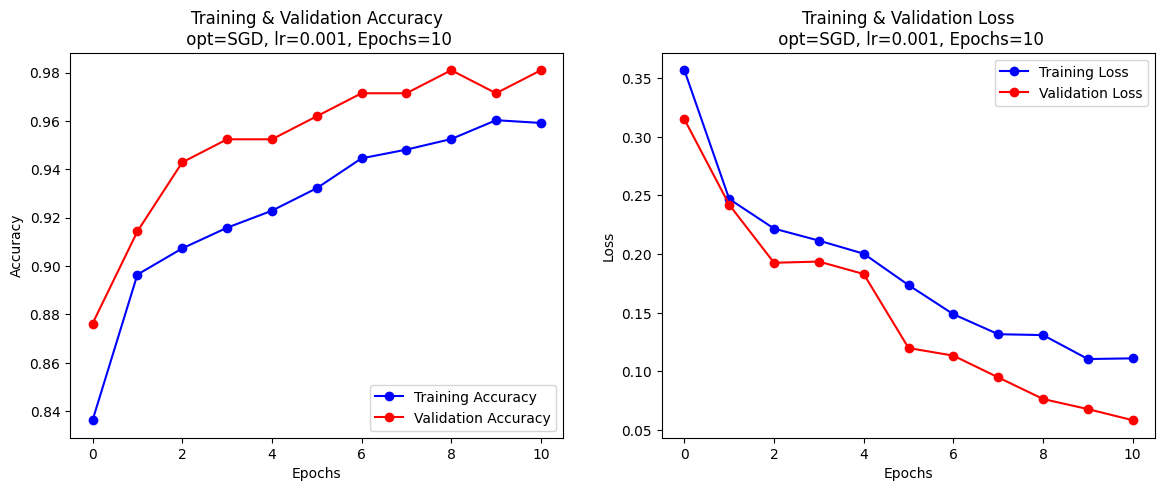

Epoch 1/5
328/328 [==============================] - 128s 378ms/step - loss: 0.4089 - accuracy: 0.8107 - val_loss: 0.4151 - val_accuracy: 0.7524 - lr: 5.0000e-04
Epoch 2/5
328/328 [==============================] - 121s 368ms/step - loss: 0.2867 - accuracy: 0.8833 - val_loss: 0.3229 - val_accuracy: 0.8381 - lr: 5.0000e-04
Epoch 3/5
328/328 [==============================] - 120s 364ms/step - loss: 0.2616 - accuracy: 0.8907 - val_loss: 0.2734 - val_accuracy: 0.8762 - lr: 5.0000e-04
Epoch 4/5
328/328 [==============================] - 121s 369ms/step - loss: 0.2378 - accuracy: 0.9050 - val_loss: 0.2415 - val_accuracy: 0.9238 - lr: 5.0000e-04
Epoch 5/5
328/328 [==============================] - 121s 369ms/step - loss: 0.2221 - accuracy: 0.9074 - val_loss: 0.2279 - val_accuracy: 0.9333 - lr: 5.0000e-04
Number of Layers In the Base Model: 190
Epoch 5/10
328/328 [==============================] - 128s 378ms/step - loss: 0.2047 - accuracy: 0.9177 - val_loss: 0.1866 - val_accuracy: 0.9238 - lr

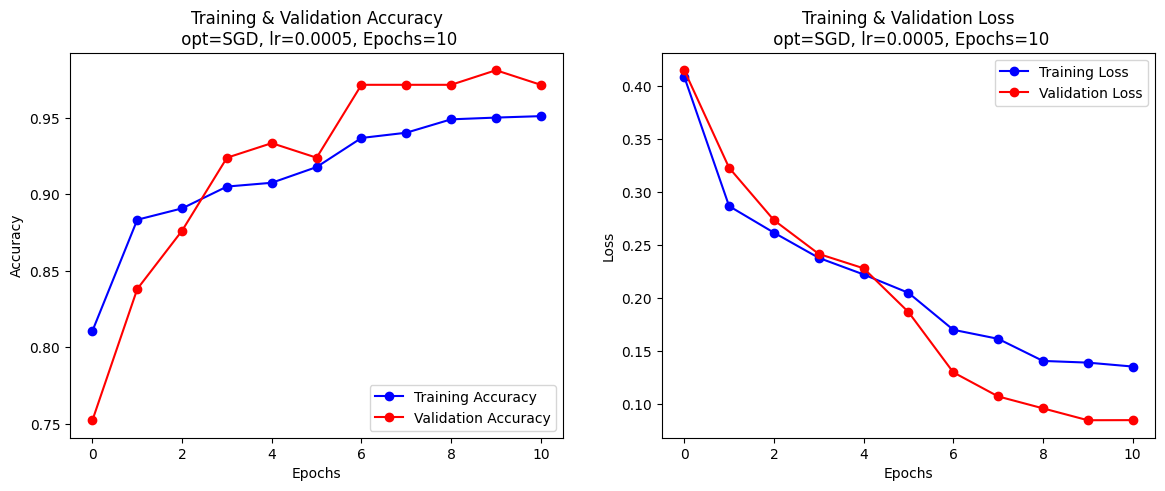

Epoch 1/5
328/328 [==============================] - 125s 371ms/step - loss: 0.5826 - accuracy: 0.7056 - val_loss: 0.7068 - val_accuracy: 0.5238 - lr: 1.0000e-04
Epoch 2/5
328/328 [==============================] - 121s 369ms/step - loss: 0.4532 - accuracy: 0.7750 - val_loss: 0.6034 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 3/5
328/328 [==============================] - 119s 363ms/step - loss: 0.3863 - accuracy: 0.8200 - val_loss: 0.5250 - val_accuracy: 0.7143 - lr: 1.0000e-04
Epoch 4/5
328/328 [==============================] - 121s 367ms/step - loss: 0.3552 - accuracy: 0.8434 - val_loss: 0.4987 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 5/5
328/328 [==============================] - 120s 364ms/step - loss: 0.3276 - accuracy: 0.8571 - val_loss: 0.4698 - val_accuracy: 0.7238 - lr: 1.0000e-04
Number of Layers In the Base Model: 190
Epoch 5/10
328/328 [==============================] - 129s 377ms/step - loss: 0.3033 - accuracy: 0.8710 - val_loss: 0.4020 - val_accuracy: 0.8190 - lr

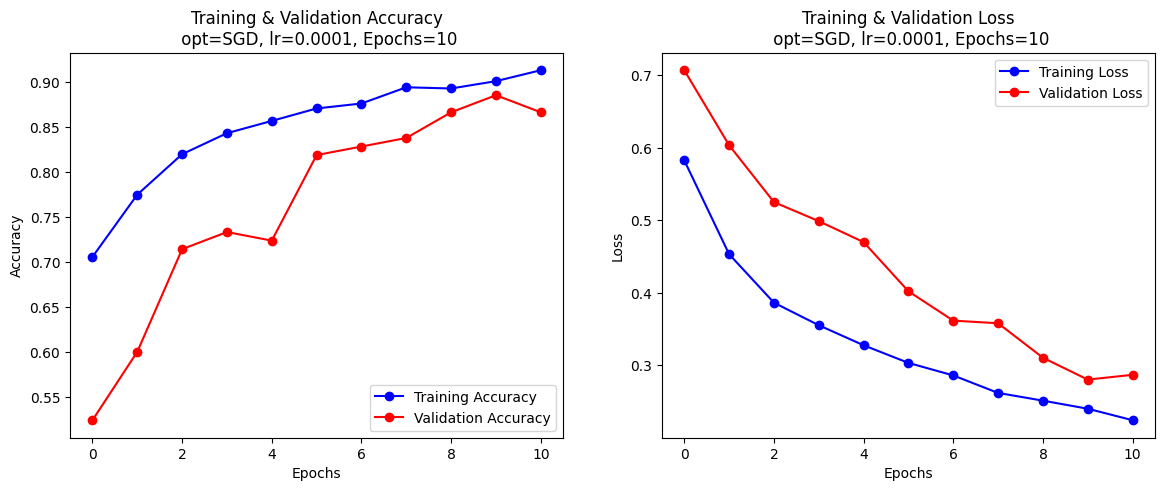

Epoch 1/10
328/328 [==============================] - 125s 372ms/step - loss: 0.3514 - accuracy: 0.8466 - val_loss: 0.3606 - val_accuracy: 0.7905 - lr: 0.0010
Epoch 2/10
328/328 [==============================] - 122s 370ms/step - loss: 0.2479 - accuracy: 0.8976 - val_loss: 0.3381 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/10
328/328 [==============================] - 120s 364ms/step - loss: 0.2266 - accuracy: 0.9048 - val_loss: 0.2332 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 4/10
328/328 [==============================] - 120s 366ms/step - loss: 0.2107 - accuracy: 0.9154 - val_loss: 0.2255 - val_accuracy: 0.9238 - lr: 0.0010
Epoch 5/10
328/328 [==============================] - 119s 361ms/step - loss: 0.1994 - accuracy: 0.9211 - val_loss: 0.1875 - val_accuracy: 0.9238 - lr: 0.0010
Epoch 6/10
328/328 [==============================] - 121s 368ms/step - loss: 0.1913 - accuracy: 0.9211 - val_loss: 0.1954 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 7/10
328/328 [==========================

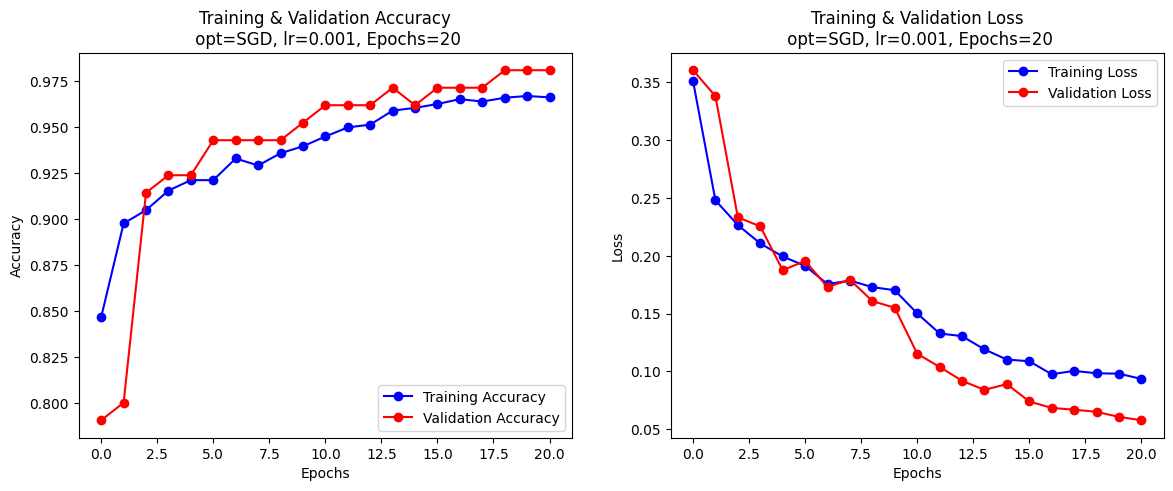

Epoch 1/10
328/328 [==============================] - 124s 369ms/step - loss: 0.4214 - accuracy: 0.8096 - val_loss: 0.4501 - val_accuracy: 0.7429 - lr: 5.0000e-04
Epoch 2/10
328/328 [==============================] - 120s 365ms/step - loss: 0.3041 - accuracy: 0.8694 - val_loss: 0.3721 - val_accuracy: 0.8000 - lr: 5.0000e-04
Epoch 3/10
328/328 [==============================] - 120s 366ms/step - loss: 0.2759 - accuracy: 0.8807 - val_loss: 0.3021 - val_accuracy: 0.8667 - lr: 5.0000e-04
Epoch 4/10
328/328 [==============================] - 120s 366ms/step - loss: 0.2573 - accuracy: 0.8938 - val_loss: 0.3126 - val_accuracy: 0.8476 - lr: 5.0000e-04
Epoch 5/10
328/328 [==============================] - 118s 360ms/step - loss: 0.2371 - accuracy: 0.9014 - val_loss: 0.2443 - val_accuracy: 0.9238 - lr: 5.0000e-04
Epoch 6/10
328/328 [==============================] - 120s 364ms/step - loss: 0.2257 - accuracy: 0.9095 - val_loss: 0.2271 - val_accuracy: 0.9429 - lr: 5.0000e-04
Epoch 7/10
328/328 [==

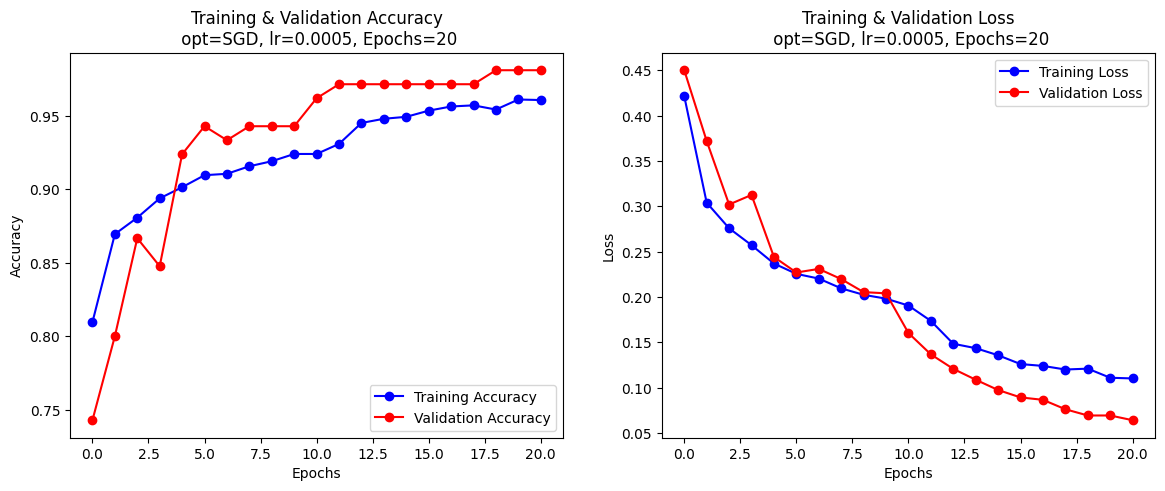

Epoch 1/10
328/328 [==============================] - 124s 367ms/step - loss: 0.5359 - accuracy: 0.7298 - val_loss: 0.6152 - val_accuracy: 0.5905 - lr: 1.0000e-04
Epoch 2/10
328/328 [==============================] - 120s 365ms/step - loss: 0.4386 - accuracy: 0.7955 - val_loss: 0.5280 - val_accuracy: 0.6762 - lr: 1.0000e-04
Epoch 3/10
328/328 [==============================] - 120s 365ms/step - loss: 0.3904 - accuracy: 0.8274 - val_loss: 0.4755 - val_accuracy: 0.7524 - lr: 1.0000e-04
Epoch 4/10
328/328 [==============================] - 120s 364ms/step - loss: 0.3608 - accuracy: 0.8434 - val_loss: 0.4392 - val_accuracy: 0.7714 - lr: 1.0000e-04
Epoch 5/10
328/328 [==============================] - 119s 361ms/step - loss: 0.3360 - accuracy: 0.8609 - val_loss: 0.4153 - val_accuracy: 0.7905 - lr: 1.0000e-04
Epoch 6/10
328/328 [==============================] - 119s 361ms/step - loss: 0.3176 - accuracy: 0.8651 - val_loss: 0.3997 - val_accuracy: 0.7905 - lr: 1.0000e-04
Epoch 7/10
328/328 [==

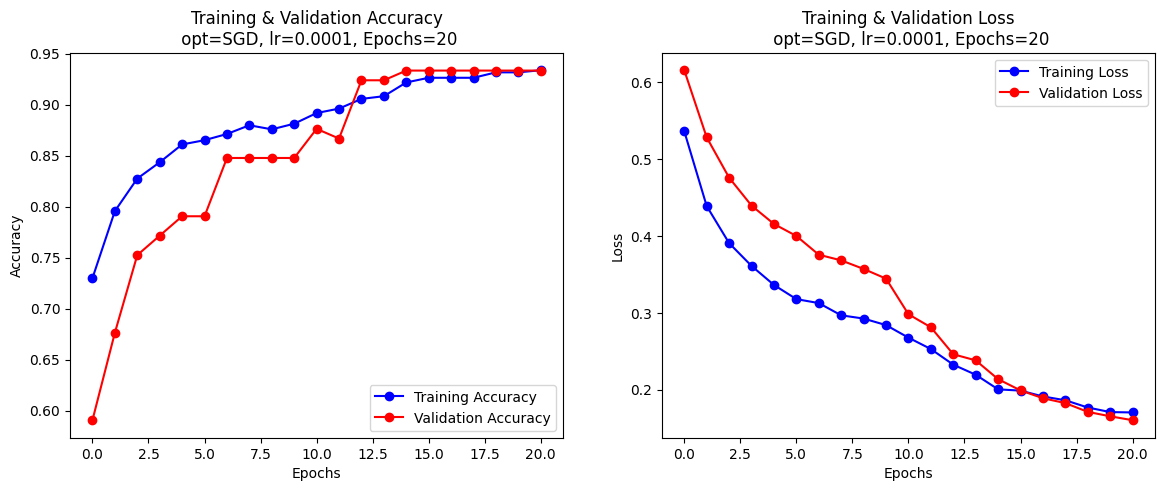

Epoch 1/20
328/328 [==============================] - 127s 375ms/step - loss: 0.3751 - accuracy: 0.8282 - val_loss: 0.3640 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/20
328/328 [==============================] - 119s 362ms/step - loss: 0.2567 - accuracy: 0.8940 - val_loss: 0.2525 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 3/20
328/328 [==============================] - 121s 367ms/step - loss: 0.2270 - accuracy: 0.9088 - val_loss: 0.2073 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 4/20
328/328 [==============================] - 120s 364ms/step - loss: 0.2107 - accuracy: 0.9141 - val_loss: 0.1986 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 5/20
328/328 [==============================] - 120s 366ms/step - loss: 0.2025 - accuracy: 0.9196 - val_loss: 0.1804 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 6/20
328/328 [==============================] - 121s 368ms/step - loss: 0.1970 - accuracy: 0.9208 - val_loss: 0.1784 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 7/20
328/328 [==========================

UnknownError: ignored

In [11]:
Epochs = [10, 20, 40]
learning_rates= [0.001, 0.0005, 0.0001]

opt = SGD

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-10,
    cooldown = 0,
    verbose = 1
)

lr_epoch_test_acc = {}
lr_epoch_test_loss = {}
for Epoch in Epochs:
  initial_epochs = Epoch//2
  for lr in learning_rates:
    base_model = create_base_model()
    model = get_pre_trained_model(base_model)
    # Training the model with all layers frozen
    model.compile(loss='binary_crossentropy',
                optimizer = opt(learning_rate=lr), metrics='accuracy')
    # model.summary()
    history = model.fit(ds_train,
              batch_size=BATCH, epochs=initial_epochs,
              validation_data=ds_val,
              callbacks=[learning_rate_reduction],
              steps_per_epoch=(len(df_train)/BATCH),
              validation_steps=(len(df_val)/BATCH))
    # Evaluate the Accuracy and Loss (Before Fine Tuning)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # adding fine tuning
    add_fine_tuning(base_model)
    model.compile(loss='binary_crossentropy',
                optimizer = opt(learning_rate=lr/10), metrics='accuracy')
    history_fine = model.fit(ds_train,
                        batch_size=BATCH,
                        epochs=Epoch,
                        initial_epoch=history.epoch[-1],
                        validation_data=ds_val,
                        callbacks=[learning_rate_reduction],
                        steps_per_epoch=(len(df_train)/BATCH),
                        validation_steps=(len(df_val)/BATCH))
    # Evaluate the Accuracy and Loss (After Fine Tuning):

    test_loss, test_accuracy = model.evaluate(ds_test, verbose=0)
    lr_epoch_tuple = (Epoch, lr)
    lr_epoch_test_acc[lr_epoch_tuple] = test_accuracy
    lr_epoch_test_loss[lr_epoch_tuple] = test_loss
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    train_acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']
    train_loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']

    # Create a figure and subplot
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    # Plot the training and validation accuracy
    axs[0].plot(train_acc, 'bo-', label='Training Accuracy')
    axs[0].plot(val_acc, 'ro-', label='Validation Accuracy')
    axs[0].set_title(f'Training & Validation Accuracy\n opt={opt.__name__}, lr={lr}, Epochs={Epoch}')
    # axs[0].title.set_size(10) # if title is too big, change the size here
    axs[0].legend(loc='lower right')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")

    # Plot the training and validation loss
    axs[1].plot(train_loss, 'bo-', label='Training Loss')
    axs[1].plot(val_loss, 'ro-', label='Validation Loss')
    axs[1].set_title(f'Training & Validation Loss\n opt={opt.__name__}, lr={lr}, Epochs={Epoch}')
    # axs[1].title.set_size(10) # if title is too big, change the size here
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.2)

    plt.show()


Print the Loss & Accuracy Dictionaries

In [ ]:
print(f"Test Accuracy and Loss Results with Optimizer: {opt.__name__}")
print()
print()
def print_results_dict(Accuracy, Loss):
    print("Print Accuracy Results")
    for key, val in Accuracy.items():
        epochs, lr = key
        print(f"Epochs Number = {epochs}, Learning Rate = {lr}, Accuracy = {val:.3f}")
    print()
    print()
    print("Print Loss Results")
    for key, val in Loss.items():
        epochs, lr = key
        print(f"Epochs Number = {epochs}, Learning Rate = {lr}, Loss = {val:.3f}")


print_results_dict(lr_epoch_test_acc, lr_epoch_test_loss)